In [1]:
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def pprint(x, x_name):
    if len(x.shape) > 1:
        print(f"{x_name} =\n{x}")
    else:
        print(f"{x_name} = {x}")

### Dataset = [Optical recognition of handwritten digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset)
Scikit-learn (usually abbreviated sklearn) provides a collection of standard datasets that are suitable for testing a classification algorithm (see https://scikit-learn.org/stable/datasets.html
for a list of the available datasets and usage instructions). In this exercise, we want to recognize handwritten digits, which is a typical machine learning application. The dataset digits consists of
1797 small images with one digit per image.
Load the dataset from sklearn and extract the data:

# 1. Exploring the Data

In [2]:
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


Note that data is flattened (1-dimensional) version of images. What is the size of these images (the numpy attribute shape might come in handy)? Visualize one image of a 3 using the imshow function from `matplotlib.pyplot`, trying the two interpolation methods in the code:

In [3]:
pprint(data, "data")

data =
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


### What is the size of the image?

In [4]:
data.shape

(1797, 64)

The data is a flattened vector of the 8x8 pixel 16 bit images, hence the length of 64.

In [5]:
target

array([0, 1, 2, ..., 8, 9, 8])

In [6]:
np.where(target == 3)[0][0]

3

In [7]:
img = data[[3]]

assert len(img.shape) == 2

pprint(img, "img")

img =
[[ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
   1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
  12. 12.  1.  0.  0.  0.  0.  0.  1. 10.  8.  0.  0.  0.  8.  4.  5. 14.
   9.  0.  0.  0.  7. 13. 13.  9.  0.  0.]]


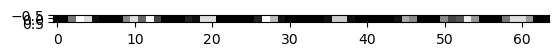

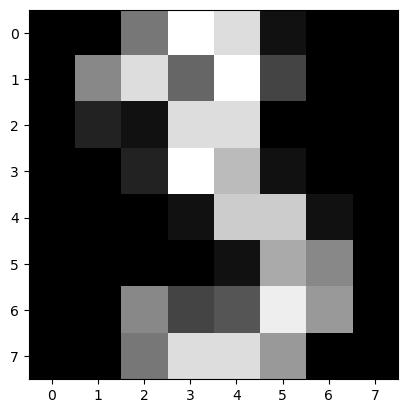

In [8]:
plt.figure()
plt.gray()
plt.imshow(img, interpolation = "nearest")
plt.show()

plt.figure()
plt.gray()
plt.imshow(np.reshape(img, (8,8)) , interpolation = "nearest")
plt.show()

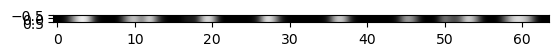

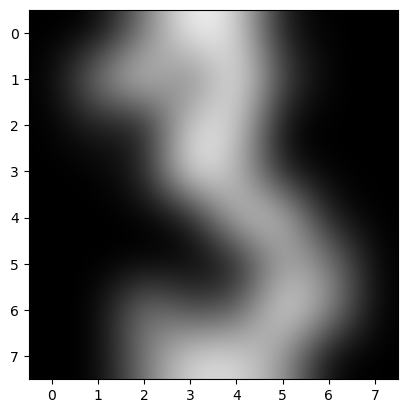

In [9]:
plt.figure()
plt.gray()
plt.imshow(img , interpolation = "bicubic")
plt.show()

plt.figure()
plt.gray()
plt.imshow(np.reshape(img, (8,8)) , interpolation = "bicubic")
plt.show()

We will only work with digits "3" and "9" to get a two-class problem. Please filter the dataset such that only these two digits are left. Split this filtered dataset in a training and a test set (#train/#test = 3/2). Sklearn provides a convenient function to separate the data into a training and a test set:

In [10]:
from sklearn import model_selection
X_filtered = data[np.in1d(target, [3,9])]
y_filtered = target[np.in1d(target, [3,9])]

X_train , X_test , y_train , y_test = \
    model_selection.train_test_split(X_filtered, y_filtered, test_size = 0.4, random_state = 0)

# 2. Hand-crafted classifier

To better appreciate the achievements of machine learning, we will start with a hand-crafted classifier

## 2.1 Feature construction

To facilitate visualization, you should construct a 2-dimensional feature space with any formula over the 64 original pixels you can come up with. You may, for example, choose two pixels that seem to have a big influence for the distinction between 3's and 9's. To identify suitable pixels, you may want to look at the average images for the two classes - pixels that tend to be bright in one class and dark in the other are good candidates. You can also use some clever linear or non-linear combination of multiple pixels into 2 features, for example: $\hat{f}_1 = 0.3 \cdot f_{23} + 42 \cdot \frac{f_13}{f_64}$ and $\hat{f}_2 = f_{33} - f_{62}$. Of course, the quality of your features determines the achievable error and therefore is a limiting factor for the quality of your predictions. Your dimension reduction procedure should be callable through a function `features2d`:
$\text{features = features2d(x)}$
where x is a #instances × 64 matrix and features has shape #instances × 2.

IDF: Create a dimentionality reduction function to reduce the information found in 64 pixels (features) to 2 arbirtrarily set features

In [11]:
def features2d(x):
    """
    - Input: np.array | shape = (N, 64)
    - Output: np.array | shape = (N, 2)
    - Algorithm:
        Computes the mean of the upper half and the lower half of the array
    """

    f1 = np.mean(x[:, 0:32], axis = 1)
    f2 = np.mean(x[:, 32:64], axis = 1)

    dim_red = np.stack([f1, f2], axis = 1)
    
    return dim_red

In [12]:
X_train_red = features2d(X_train)
X_test_red = features2d(X_test)

## 2.2 Scatterplot

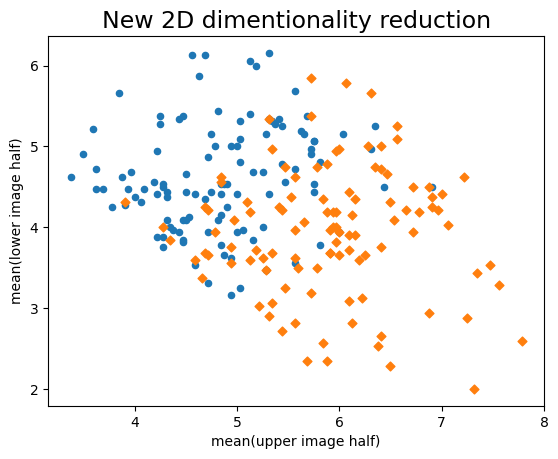

In [13]:
plt.figure()
plt.scatter(X_train_red[y_train == 3][:, 0], X_train_red[y_train == 3][:, 1], s=20)
plt.scatter(X_train_red[y_train == 9][:, 0], X_train_red[y_train == 9][:, 1], s=20, marker="D")
plt.title("New 2D dimentionality reduction", fontsize=17)
plt.xlabel("mean(upper image half)")
plt.ylabel("mean(lower image half)")
plt.show()

## 2.3 Decision rule

First define a very simple decision rule: Find the mean of the 2D feature vectors of each class in the training set and assign each test instance to the label of the nearest mean. The decision boundary
of this method is the bisector between the two means. The signature of the function is supposed to look like this:
$$\text{predicted_labels = nearest_mean(training_features, training_labels, test_features)}$$
where `training_features` and `test_features` are the outputs of `features2d()` for training and test data respectively. Compute and report the training and test errors of the classifier (i.e. the ratio $\frac{#FP + #FN}{N}$ on the respective dataset).

If your features are very informative, this classifier may already have good performance. Otherwise, you can define a more sophisticated decision boundary by picking good β and b in the formula $ybi = sign(xi · β + b)$. If this is still not satisfactory, improve your features. Again compute and report the test error of your formula.

IDF: Create a decision rule based on class means of each feature. The decision is made based on the closes mean (bisecting function, perpendicular bisector in 2D)

In [14]:
def bisector(point1, point2):
    """
    Takes two vectors and finds the bisecting function
    - point1: np.array, .shape = (2)
    - point1: np.array, .shape = (2)
    - return: list, len = 2

    - What is a bisector? https://www.youtube.com/watch?v=9SSVIa2npK8
    The bisector is the function that goes through the midpoint between two datapoints and (2) has a perpendicular slope to the vector between the datapoints
    """


    # Find the midpoint of the two vectors by taking the average of the two points
    midpoint = (point1 + point2) / 2

    # Find the slope of the vector
    m = point1 - point2
    m = m[1] / m[0]

    # Invert the slope
    m_i = -1 / m

    # Find the b coefficient in y = mx + b
    b = midpoint[1] - (m_i * midpoint[0])

    return [m_i, b]

In [15]:
def classifier(X, m, b, label1, label2):
    """
    Classifies a response dataset based on a bisecting function
    - X: np.array, .shape = 2
    - m: slope,
    - b: b coefficient
    - label1: int
    - label2: int
    - return: np.array, .shape = 1
    """
    return np.where(X[:,1] > (X[:,0] * m + b), label1, label2).astype(int)

In [16]:
def nearest_mean(X, y, y_2_pred):
    """
    - param X_train: train set , type == np.array() , .shape == (N_train, 2)
    - y_train: test set | type == np.array() , .shape == (N_test, 2)
    - param X_test: train labels, .shape = (N_test)
    - return: predicted class, np.array, .shape = (N_test)
    """
    means_train = np.array(
        [np.mean(X[y == 3], axis=0),
         np.mean(X[y == 9], axis=0)]
    )

    m, b = bisector(means_train[0], means_train[1])

    pred = classifier(y_2_pred, m, b, label1=3, label2=9)

    return pred

In [17]:
y_test_pred = nearest_mean(X=X_train_red, y=y_train, y_2_pred=X_test_red)

pprint(y_test_pred, "y_test_pred")

y_test_pred = [9 9 9 3 9 9 3 3 3 3 3 9 9 3 9 9 3 3 9 9 9 9 3 3 3 3 3 9 9 3 9 9 9 3 9 3 9
 3 3 3 3 9 3 3 3 3 3 9 3 3 3 9 9 9 9 9 9 3 9 9 3 3 3 3 9 9 3 9 9 9 9 3 9 3
 9 9 9 3 9 9 3 9 3 9 9 3 9 3 9 9 3 9 9 9 9 9 9 9 3 9 3 3 3 3 9 9 3 3 3 9 3
 9 9 9 3 3 9 9 3 9 9 9 3 3 9 3 9 9 3 9 9 9 3 9 9 3 3 9 3 9 9 3 9 3 9 9]


In [18]:
y_train_pred = nearest_mean(X=X_train_red, y=y_train, y_2_pred=X_train_red)

pprint(y_train_pred, "y_train_pred")

y_train_pred = [9 9 9 3 9 3 3 3 9 9 9 3 3 3 9 9 3 9 9 3 9 3 9 9 3 3 9 9 9 3 9 9 3 9 9 3 3
 3 3 3 3 3 9 9 3 3 9 9 3 9 3 9 9 9 9 3 3 9 3 3 9 9 3 9 3 3 9 3 3 3 3 9 9 3
 9 9 9 3 3 9 3 3 3 3 3 9 3 3 3 9 3 9 9 9 9 9 9 3 9 3 3 3 3 3 3 9 3 3 9 9 9
 9 9 9 9 3 3 9 3 9 3 9 3 3 3 3 3 3 9 9 3 9 3 9 3 3 9 9 9 3 3 3 9 9 3 9 3 3
 3 3 3 3 3 3 9 9 9 9 9 9 3 3 3 9 3 3 9 9 9 3 3 3 3 3 3 9 3 9 9 9 9 3 9 3 9
 3 3 3 9 3 9 3 9 9 3 3 9 3 3 3 3 9 3 9 3 9 9 3 9 3 3 3 3 3 3 9 3]


**Test error**

In [19]:
np.sum((y_test_pred - y_test) != 0) / len(y_test_pred)

0.21232876712328766

**Train error**

In [20]:
np.sum((y_train_pred - y_train) != 0) / len(y_train_pred)

0.17972350230414746

IDF: Training error is overconfident

## 2.4 Visualize the decision regions

An image of the decision regions can be quite helpful for analyzing classier performance. The simplest way to do this is to create a grid (i.e. an image) where each pixel position represents
a feature coordinate, and the pixel is colored with the corresponding predicted class label. Since you created the features on your own, you must nd a sensible transformation (i.e translation and
scaling) from feature coordinates to grid coordinates so that your image covers the interesting part of the feature domain. A 200×200 grid provides sucient resolution. Plot this image to visualize the
decision regions. Overlay the plot with two markers for the two class means and with a scatterplot of the test data, marked according to their ground truth labels as in task 2.2. Consult the matplotlib
documentation to nd out how several layers of information can be overlayed in the same plot. Plot the decision boundary of the two models from the previous subtask.

IDF: Create decision rule explicitly

In [21]:
means_train = np.array(
        [np.mean(X_train_red[y_train == 3], axis=0),
         np.mean(X_train_red[y_train == 9], axis=0)]
    )

m, b = bisector(means_train[0], means_train[1])

IDF: Create coordinate grid and "discrete" values for each coordinate

In [22]:
x = np.linspace(3, 9, 400) # x-limits and resolution arbitrarily set after plotting and adjusting
y = np.linspace(1, 7, 400) # x-limits and resolution arbitrarily set after plotting and adjusting

X, Y = np.meshgrid(x, y)

pos = np.dstack((X, Y))

L = np.zeros(X.shape)

for x in range(0, X.shape[0]):
    for y in range(0, X.shape[1]):
        L[x, y] = classifier(np.array([[X[x,y], Y[x,y]]]), m, b, label1=3, label2=9)



IDF: Plot

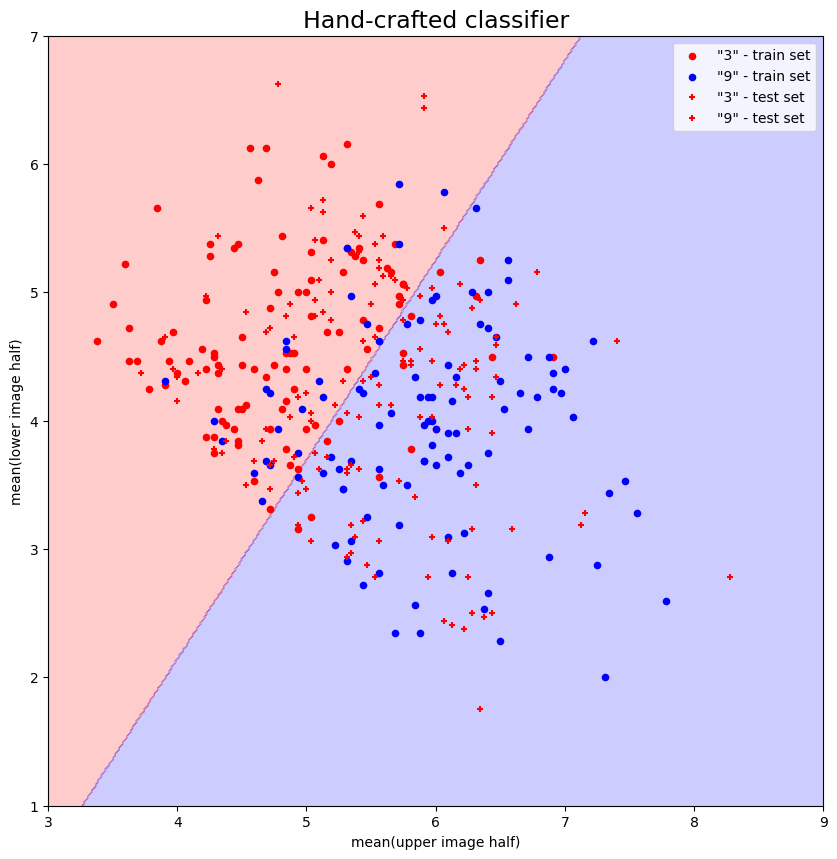

In [23]:
plt.figure(figsize=(10,10))

plt.contourf(X, Y, L, levels=2, alpha=0.2, colors=["red","blue"])#, shading="auto")
plt.scatter(X_train_red[y_train == 3][:, 0], X_train_red[y_train == 3][:, 1], s=20, c="red", label="\"3\" - train set")
plt.scatter(X_train_red[y_train == 9][:, 0], X_train_red[y_train == 9][:, 1], s=20, c="blue", label="\"9\" - train set")
plt.scatter(X_test_red[y_test == 3][:, 0], X_test_red[y_test == 3][:, 1], s=20, c="red", marker="+", label="\"3\" - test set")
plt.scatter(X_test_red[y_test == 9][:, 0], X_test_red[y_test == 9][:, 1], s=20, c="red", marker="+", label="\"9\" - test set")

plt.legend()

plt.title("Hand-crafted classifier", fontsize=17)
plt.xlabel("mean(upper image half)")
plt.ylabel("mean(lower image half)")
plt.show()